# 變異prompt
設定初始的prompt 判斷漲跌並計算其準確率和期望值  
再拿最高的年化報酬率的prompt變異
建立stack 將prompt 依序由表現好排到表現差
然後將比較好的拿來變異
最好的promt變異五次如果準確率沒有提升，便將其刪除，改用第二好的prompt

使用期交所的歷史台指期資料  
存入的#yes #no #unknown日期是當天的日期，由前一天的新聞判斷  

# 版本
python 3.11.7

In [1]:
# %pip install langchain_google_genai
# %pip install mplfinance
# %pip install google-generativeai
# %pip install langchain
# %pip install -U langchain-google-genai

In [2]:
import os
import textwrap
import math
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

import google.generativeai as genai
from langchain.schema.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from google.generativeai.types import HarmBlockThreshold
from google.ai.generativelanguage_v1 import HarmCategory

from IPython.display import display
from IPython.display import Markdown

model = 'gemini-1.5-flash'
temperature = 1
top_p = 0.9
seed = 0

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

llm = ChatGoogleGenerativeAI(
                google_api_key = os.getenv('GEMINI_API_KEY'),
                model=model,
                temperature=temperature,
                top_p=top_p,
                seed=seed,
                safety_settings={
                        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
                        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT : HarmBlockThreshold.BLOCK_NONE,
                
            })

path_out = "out_mutate_tx/gemini/"

/Users/yanyifu/Documents/_Coding/Gen-AI-Stock-Master/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1727435344.619797 23755814 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache, work_serializer_dispatch
I0000 00:00:1727435344.629044 23755814 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1727435344.630985 23755814 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


# functions
step1 問LLM漲跌  
step2 變異

27行 可以調整batch size  

## 主程式

In [3]:
# 透過前一天的新聞判斷今日的股市走勢
import time
import os
import json
import pandas as pd
from datetime import datetime, timedelta

def analyze_prompt(stock_ids, st, et, init_prompt, mutate_prompt):
    path_price_his = (os.path.abspath(os.getcwd())) + "/history_data/tw/twii_history.csv"

    # 讀取CSV檔案
    df_price_his = pd.read_csv(path_price_his, encoding='utf-8')
    df_price_his['日期'] = pd.to_datetime(df_price_his['日期'], format='%Y%m%d')
    df_price_his = df_price_his[(st <= df_price_his['日期']) & (df_price_his['日期'] <= et)]

    idx = 1
    batch_size = 500
    output_data = {}  # 使用字典來存儲每一天的輸出數據

    while idx < len(df_price_his):
        batch = []
        for i in range(batch_size):
            if idx + i >= len(df_price_his):
                break

            # 取得前一日的日期
            news_date = df_price_his.iloc[idx + i]['日期'] 
            news_date -= timedelta(days=1)

            # 存儲所有股票的新聞資料
            text_news = ""
            for j, stock_id in enumerate(stock_ids):
                path_news_file = (os.path.abspath(os.getcwd())) + "/history_data/tw/news_title/" + stock_id + "news_title.json"
                with open(path_news_file, 'r', encoding='utf-8') as f:
                    news_data = json.load(f)
                    text_news = "權值股的熱門新聞標題"
                    text_news += f"{news_data[news_date.strftime('%Y%m%d')]} \n"

            # 設置初始消息列表，包括 SystemMessage 和第一個 HumanMessage
            messages = [
                ("system", "你是一個厲害的股市操盤手，專長是當日沖消"),
                ("human",
                f"""
                以下是台灣股市權值股的新聞標題，
                {text_news}

                請依據以下判斷依據判斷權值股對大盤（實際操作使用台指期）隔日開盤時買進收盤時賣出的獲利可能性
                {mutate_prompt}
                
                請綜合以上資訊，判斷明日當沖台指期是否可能獲利，有可能請則只回答#yes，否則只回答#no，如果無關則回答#unknown，請盡量不要回答 #unknown
                
                """)
            ]
            batch.append(messages)

        res = llm.batch(batch)

        for i in range(len(res)):
            # 被預測的日期
            date_str = df_price_his.iloc[idx + i]['日期'].strftime('%Y%m%d')
            output_data[date_str] = {
                "token": res[i].usage_metadata,
                "raw_data": res[i].content,
            }

        # time.sleep(60)
        idx += batch_size

    # 將所有輸出數據寫入到同一個json檔案中
    data = {
        "model": model,
        "temperature": temperature,
        "top_p": top_p,
        "seed": seed,
        "init_prompt": init_prompt,
        "mutate_prompt": mutate_prompt,
        "output_data": output_data,
    }
    
    return data

def mutating_prompt(text_in):
    messages = [
        ("human",
        f"""
        請用以下指令產生1個清晰和有條理的變體，同時保留語意：{text_in}
        """)
    ]
    response = llm.invoke(messages)
    # print(f'變異結果： {response.content}')
    # time.sleep(60)
    return response.content

# 計算表現

In [4]:
import pandas as pd
import json
import os

def eval(anal_data):
    # 計算準確率和平均報酬率
    gain = []
    loss = []

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    token_input = 0
    token_output = 0

    path_price_his = (os.path.abspath(os.getcwd())) + "/history_data/tw/twii_history.csv"
    df_price_his = pd.read_csv(path_price_his, encoding='utf-8')
    df_price_his['日期'] = pd.to_datetime(df_price_his['日期'], format='%Y%m%d')

    output_data = anal_data["output_data"]
    for date_str, result in output_data.items():
        token_input += result["token"]["input_tokens"]
        token_output += result["token"]["output_tokens"]
        sig_str = result["raw_data"]
        sig = 0

        if "unknown" in sig_str:
            sig = 0
        elif "yes" in sig_str:
            sig = 1
        elif "no" in sig_str:
            sig = -1
        else:
            sig = 0

        df_price = df_price_his[df_price_his['日期'] == pd.to_datetime(date_str, format='%Y%m%d')]

        if df_price.empty:
            continue

        rtn = (df_price.iloc[0]['收盤指數'] - df_price.iloc[0]['開盤指數']) / df_price.iloc[0]['開盤指數']

        if pd.isna(rtn):
            rtn = 0

        if sig > 0:
            if rtn > 0:
                tp += 1
                gain.append(rtn)
            else:
                fp += 1
                loss.append(rtn)
        elif sig == -1:
            if rtn < 0:
                tn += 1
                gain.append(-rtn)
            else:
                fn += 1
                loss.append(-rtn)
    
    ev = 0
    accuracy = 0
    if tp + fp + tn + fn == 0:
        accuracy = 0
        ev = 0
    elif len(gain) == 0 or len(loss) == 0:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        ev = 0
    else:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        ev = (sum(gain) / len(gain))*accuracy + (sum(loss) / len(loss))*(1-accuracy)

    eval_data = {
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "accuracy": accuracy,
        "ev": ev,
    }
    
    print(f'tp {tp}, fp {fp}, tn {tn}, fn {fn}, total:[{tp + fp + tn + fn}/{len(output_data)}]')
    print(f'Accuracy {round(accuracy, 5)}, Expected value:{round(ev,5)}')
    # print("--------------------")
    # print(f'token: input {token_input}, output {token_output}')
    # print(f'預估費用 {(token_input/1000000)*0.35 + (token_output/1000000)*0.7} USD, {((token_input/1000000)*0.35 + (token_output/1000000)*0.7)*32.6} TWD')
    # print(f'詢問次數 {len(output_data)}')
    # print()

    return accuracy, ev, eval_data

## 輸出

In [5]:
def save_data(folder_path, data):
    count = 1
    out_file = ""
    while True:
        if os.path.exists(folder_path + str(count) + ".json"):
            count += 1
        else:
            out_file = folder_path + str(count) + ".json"
            break
    json_content = json.dumps(data, ensure_ascii=False, indent=4)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    with open(out_file, "w", encoding="UTF-8") as f:
        f.write(json_content)
    
    print(f"已儲存至{out_file}")
    return out_file

# 訓練
6 7 設定執行日期  
8 權值股的股票代號 ['2308', '2317', '2330', '2382', '2412', '2454', '2881', '2882', '2891', '6505']  
20 輸出檔案路徑
60 設定變異次數上限

In [6]:
# 避免local minimum
from datetime import datetime

# 初始化
run_count = 1
start_day = datetime(2024, 2, 1)
end_day = datetime(2024, 5, 30)
out_folder = start_day.strftime('%Y%m%d') + "_" + end_day.strftime('%Y%m%d')
stock_ids = ['2308', '2317', '2330', '2382', '2412', '2454', '2881', '2882', '2891', '6505']
init_acc = 0
acc = 0
init_prompt = """
讓我們一步一步來
利多需要滿足以下條件：
企業創新策略：這是所有句子的核心主題，無論是滿足客戶需求、吸引投資者，還是促進股價增長，都是基於企業的創新策略。
滿足客戶需求：客戶需求是企業創新的首要驅動力，能否滿足客戶需求直接影響創新成敗。
吸引投資者關注：投資者的關注和信心能為企業提供必要的資金和支持，也是創新成功的重要標誌。
"""
prompt_stack = [(init_prompt, acc)]  # 初始prompt和準確率加入stack
mutate_count = 0  # 記錄變異次數
current_prompt, init_acc = prompt_stack[-1]

In [7]:
# 主迴圈
while prompt_stack:
    print(f"Run count: {run_count}")
    current_prompt, _ = prompt_stack[-1]  # 取得stack頂部的prompt和準確率
    mutate_prompt = init_prompt
    mutate_prompt = mutating_prompt(current_prompt)  # 生成變異prompt
    data_anal = analyze_prompt(stock_ids, start_day, end_day, current_prompt, mutate_prompt)
    acc, ev, data_eval = eval(data_anal)
    mutate_count += 1

    # 將新的prompt和準確率加入stack，並按準確率排序
    prompt_stack.append((mutate_prompt, acc))
    prompt_stack.sort(key=lambda x: x[1])  # 按準確率由低至高排序

    # 有比stack更高的準確率則將 counter 重置
    if acc > _:
        init_acc = acc
        mutate_count = 0  # 重置變異次數計數器
        print(f"Update prompt with accuracy: {acc}")

    if len(prompt_stack) > 1 and mutate_count >= 5:
        prompt_stack.pop()  # 移除準確率最高的prompt 避免local minimum
        mutate_count = 0  # 重置變異次數計數器
        print("Remove top prompt due to no improvement after 5 mutations.")
    elif acc > 0.9:
        acc = 0.6
        prompt_stack.pop()  # 移除準確率最高的prompt 避免local minimum
        mutate_count = 0  # 重置變異次數計數器
        print("Remove top prompt due to accuracy over 0.9.")
    elif len(prompt_stack) == 1:
        # 如果stack只剩下一個prompt，移除變異次數限制
        mutate_count = 0
        print("Single prompt in stack, removing mutation limit.")

    # # 輸出本次變異
    # print(prompt_stack)
    # print(mutate_count)
    # 終止條件
    run_count += 1

    print(data_eval)
    data_anal['eval_data'] = data_eval
    json_content = json.dumps(data_anal, ensure_ascii=False, indent=4)
    save_data(f"{path_out}train/{out_folder}/", data_anal)

    # 設定變異次數上限
    # if acc > 0.7:
    #     print("Accuracy over 0.7, stop training.")
    #     trained_prompt = prompt_stack[-1][0]
    #     print(f"Final prompt:")
    #     print(trained_prompt)
    #     break
    # el
    if run_count > 40:
        print("Run count over, stop training.")
        trained_prompt = prompt_stack[-1][0]
        print(f"Final prompt:")
        print(trained_prompt)
        break

Run count: 1
tp 9, fp 1, tn 34, fn 30, total:[74/74]
Accuracy 0.58108, Expected value:0.00105
Update prompt with accuracy: 0.581081081081081
{'tp': 9, 'fp': 1, 'tn': 34, 'fn': 30, 'accuracy': 0.581081081081081, 'ev': 0.001045573543544451}
已儲存至out_mutate_tx/gemini/train/20240201_20240530/4.json
Run count: 2
tp 1, fp 0, tn 35, fn 38, total:[74/74]
Accuracy 0.48649, Expected value:-0.00062
{'tp': 1, 'fp': 0, 'tn': 35, 'fn': 38, 'accuracy': 0.4864864864864865, 'ev': -0.0006182556305756289}
已儲存至out_mutate_tx/gemini/train/20240201_20240530/5.json
Run count: 3
tp 9, fp 3, tn 32, fn 30, total:[74/74]
Accuracy 0.55405, Expected value:0.00105
{'tp': 9, 'fp': 3, 'tn': 32, 'fn': 30, 'accuracy': 0.5540540540540541, 'ev': 0.0010538135317278287}
已儲存至out_mutate_tx/gemini/train/20240201_20240530/6.json
Run count: 4


# 測試
6/1~ 8/31

In [26]:
trained_prompt = prompt_stack[-1][0]
start_day = datetime(2024, 6, 1)
end_day = datetime(2024, 8, 31)
data_anal = analyze_prompt(stock_ids, start_day, end_day, trained_prompt, trained_prompt)
acc, ev, data_eval = eval(data_anal)
data_anal['eval_data'] = data_eval
json_content = json.dumps(data_anal, ensure_ascii=False, indent=4)
save_data(f"{path_out}test/{out_folder}/", data_anal)

tp 2, fp 1, tn 0, fn 0, total:[3/61]
Accuracy 0.66667, Expected value:0.00156
已儲存至out_mutate_tx/gemini/test/20231201_20240530/3.json


'out_mutate_tx/gemini/test/20231201_20240530/3.json'

# DEMO

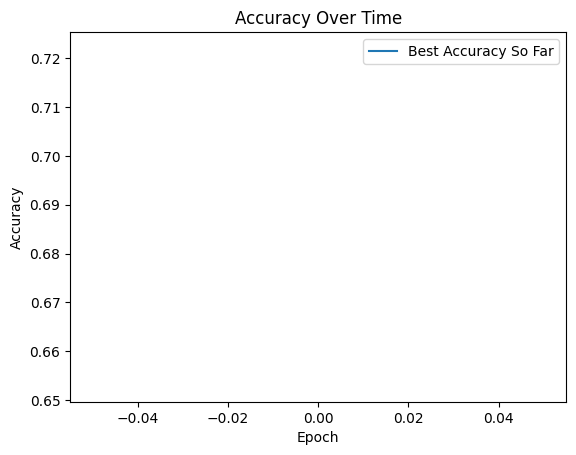

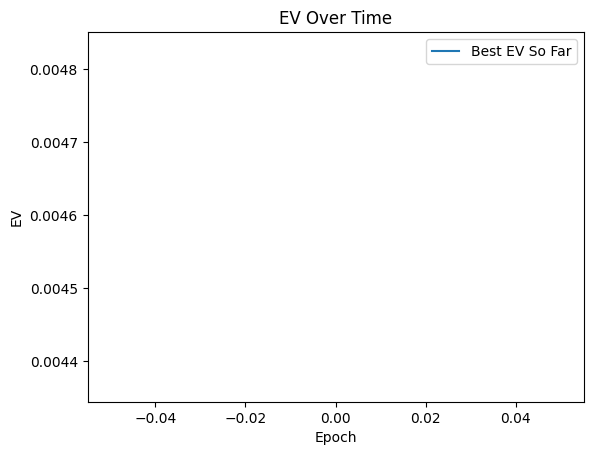

In [38]:
import json
import matplotlib.pyplot as plt
import os

accs = []
evs = []
best_accs = []
best_evs = []
best_acc = float('-inf')  # 初始化為負無窮
best_ev = float('-inf')  # 初始化為負無窮

path = f"{path_out}train/{out_folder}/"
files = os.listdir(path)
files = sorted(files)

for file in files:
    outpath = f"{path_out}train/{out_folder}/" + file
    with open(outpath, 'r', encoding='utf-8') as f:
        data = json.load(f)
        acc = data['eval_data']['accuracy']
        ev = data['eval_data']['ev']

    if acc > 0.7:
        continue

    # 追加目前的 acc 和 ev
    accs.append(acc)
    evs.append(ev)

    # 追蹤到目前為止的最佳 acc 和 ev
    if acc > best_acc:
        best_acc = acc
    if ev > best_ev:
        best_ev = ev

    # 追加最佳 acc 和 ev 的數值
    best_accs.append(best_acc)
    best_evs.append(best_ev)

# 繪製 Accuracy 圖表
# plt.plot(accs, label='Accuracy')
plt.plot(best_accs, label='Best Accuracy So Far')
plt.title('Accuracy Over Time')  # 添加標題
plt.xlabel('Epoch')  # X軸標籤
plt.ylabel('Accuracy')  # Y軸標籤
plt.legend()  # 顯示圖例
plt.show()

# 繪製 EV 圖表
# plt.plot(evs, label='EV')
plt.plot(best_evs, label='Best EV So Far')
plt.title('EV Over Time')  # 添加標題
plt.xlabel('Epoch')  # X軸標籤
plt.ylabel('EV')  # Y軸標籤
plt.legend()  # 顯示圖例
plt.show()
